# Project 1: Classify Images of Road Traffic Signs

### Objective
-  Identify and classify images of road traffic signs to enhance navigation systems and improve road safety

### **Dataset**

Source: Belgium Traffic Sign Classification Benchmark, German TSC dataset

Input variables:

Output variable (desired target):

# Table of Contents
* 1. Import Libraries
* 2. Process the dataset
* 3. Exploratory Data Analysis (EDA)
  - 3.1 Visualise sample images according to shape and type
  - 3.2 Data Distribution
* 4. Data Splitting
* 5. Data Modelling
  - 5.1 Baseline Model: MLP NN
    - Model 1.1: Shape classification using MLP NN
    - Model 1.2: Type classification using MLP NN
  - 5.2 Transfer to CNN Model
    - Model 2.1: Shape classification (converting model 1.1 into CNN)
    - Model 2.2: Type classification (converting model 1.2 into CNN)
  - 5.3 Advanced Model: VGG
    - Model 3.1: Shape classification using VGG
    - Model 3.2: Type
classification using CNN
  - Data Augmentation
* 6. Testing the model
* 7. Conclusion
* 8. Reference

## 1. Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
from sklearn.metrics import confusion_matrix, f1_score, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import cv2
import tensorflow as tf
from keras.callbacks import Callback

# show better graph
%matplotlib inline

In [3]:
from google.colab import drive
drive .mount('/content/drive')

Mounted at /content/drive


#### Connect to the dataset file from google drive

In [4]:
!cp /content/drive/'My Drive'/Assignment2/trafficsigns_dataset.zip .
!cp /content/drive/'My Drive'/Assignment2/trafficsigns_dataset_testing.zip .

# !cp /content/drive/'My Drive'/COSC2673/Assignments/Assignment2/trafficsigns_dataset.zip .
# !cp /content/drive/'My Drive'/COSC2673/Assignments/Assignment2/trafficsigns_dataset_testing.zip .

Unzip the dataset

In [5]:
import zipfile
with zipfile.ZipFile('trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
with zipfile.ZipFile('trafficsigns_dataset_testing.zip', 'r') as zip_ref_test:
    zip_ref_test.extractall('./')

## 2. Process the dataset
Collect Image Files
- Function to traverse directories recursively and collect image files from the offered dataset and additional dataset for testing

In [6]:
def collect_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_files.append(os.path.join(root, file))
    return image_files

In [7]:
all_image_files = collect_image_files('./trafficsigns_dataset')
all_test_image = collect_image_files('./trafficsigns_dataset_testing')

Create a DataFrame with image file paths in a column named 'image_path'

In [8]:
df = pd.DataFrame({'image_path': all_image_files})
df_test = pd.DataFrame({'image_path': all_test_image})

To encode the traffic sign shapes and types

In [9]:
trafficsigns_shapes = {'diamond': 0, 'hex': 1, 'round': 2, 'square': 3, 'triangle': 4}
trafficsigns_types = {'rightofway': 0, 'stop': 1, 'bicycle': 2, 'limitedtraffic': 3, 'noentry': 4, 'noparking': 5,
                      'roundabout':6, 'speed': 7, 'trafficdirective': 8, 'traveldirection': 9, 'continue': 10,
                      'crossing': 11,  'laneend': 12, 'parking': 13, 'giveway': 14, 'warning': 15}

This project involves **multi-class image classification** and features traffic signs categorised into 5 shape classes and 16 type classes, with each image being classified into one of these categories

In [10]:
def assign_class_label(image_path):
    # Split the image path by '/'
    parts = image_path.split('/')

    # Extract shape and type from the parts
    shape = parts[-3]
    trafficsign_type = parts[-2]

    # Map shape and type to corresponding class labels using the dictionaries
    shape_label = trafficsigns_shapes.get(shape, -1)  # -1 if shape not found in dictionary
    type_label = trafficsigns_types.get(trafficsign_type, -1)  # -1 if type not found in dictionary

    # Return a tuple of shape label and type label
    return (shape_label, type_label)


- Get the dataframe with image_path, shape_label and type_label

In [11]:
df['shape_label'], df['type_label'] = zip(*df['image_path'].apply(assign_class_label))
df_test['shape_label'], df_test['type_label'] = zip(*df_test['image_path'].apply(assign_class_label))

In [12]:
print(f"Shape of offered dataset: {df.shape}.\n Shape of additional dataset: {df_test.shape}")

Shape of offered dataset: (3699, 3).
 Shape of additional dataset: (2234, 3)


In [13]:
df.head()

,image_path,shape_label,type_label
0,./trafficsigns_dataset/square/laneend/00007_00...,3,12
1,./trafficsigns_dataset/square/laneend/01415_00...,3,12
2,./trafficsigns_dataset/square/laneend/00144_00...,3,12
3,./trafficsigns_dataset/square/laneend/00489_00...,3,12
4,./trafficsigns_dataset/square/laneend/01123_00...,3,12


In [14]:
df_test.head()

,image_path,shape_label,type_label
0,./trafficsigns_dataset_testing/square/laneend/...,3,12
1,./trafficsigns_dataset_testing/square/laneend/...,3,12
2,./trafficsigns_dataset_testing/square/laneend/...,3,12
3,./trafficsigns_dataset_testing/square/laneend/...,3,12
4,./trafficsigns_dataset_testing/square/laneend/...,3,12


## 3. Exploratory Data Analysis (EDA)

## 3.1 Visualise sample images according to shape and type

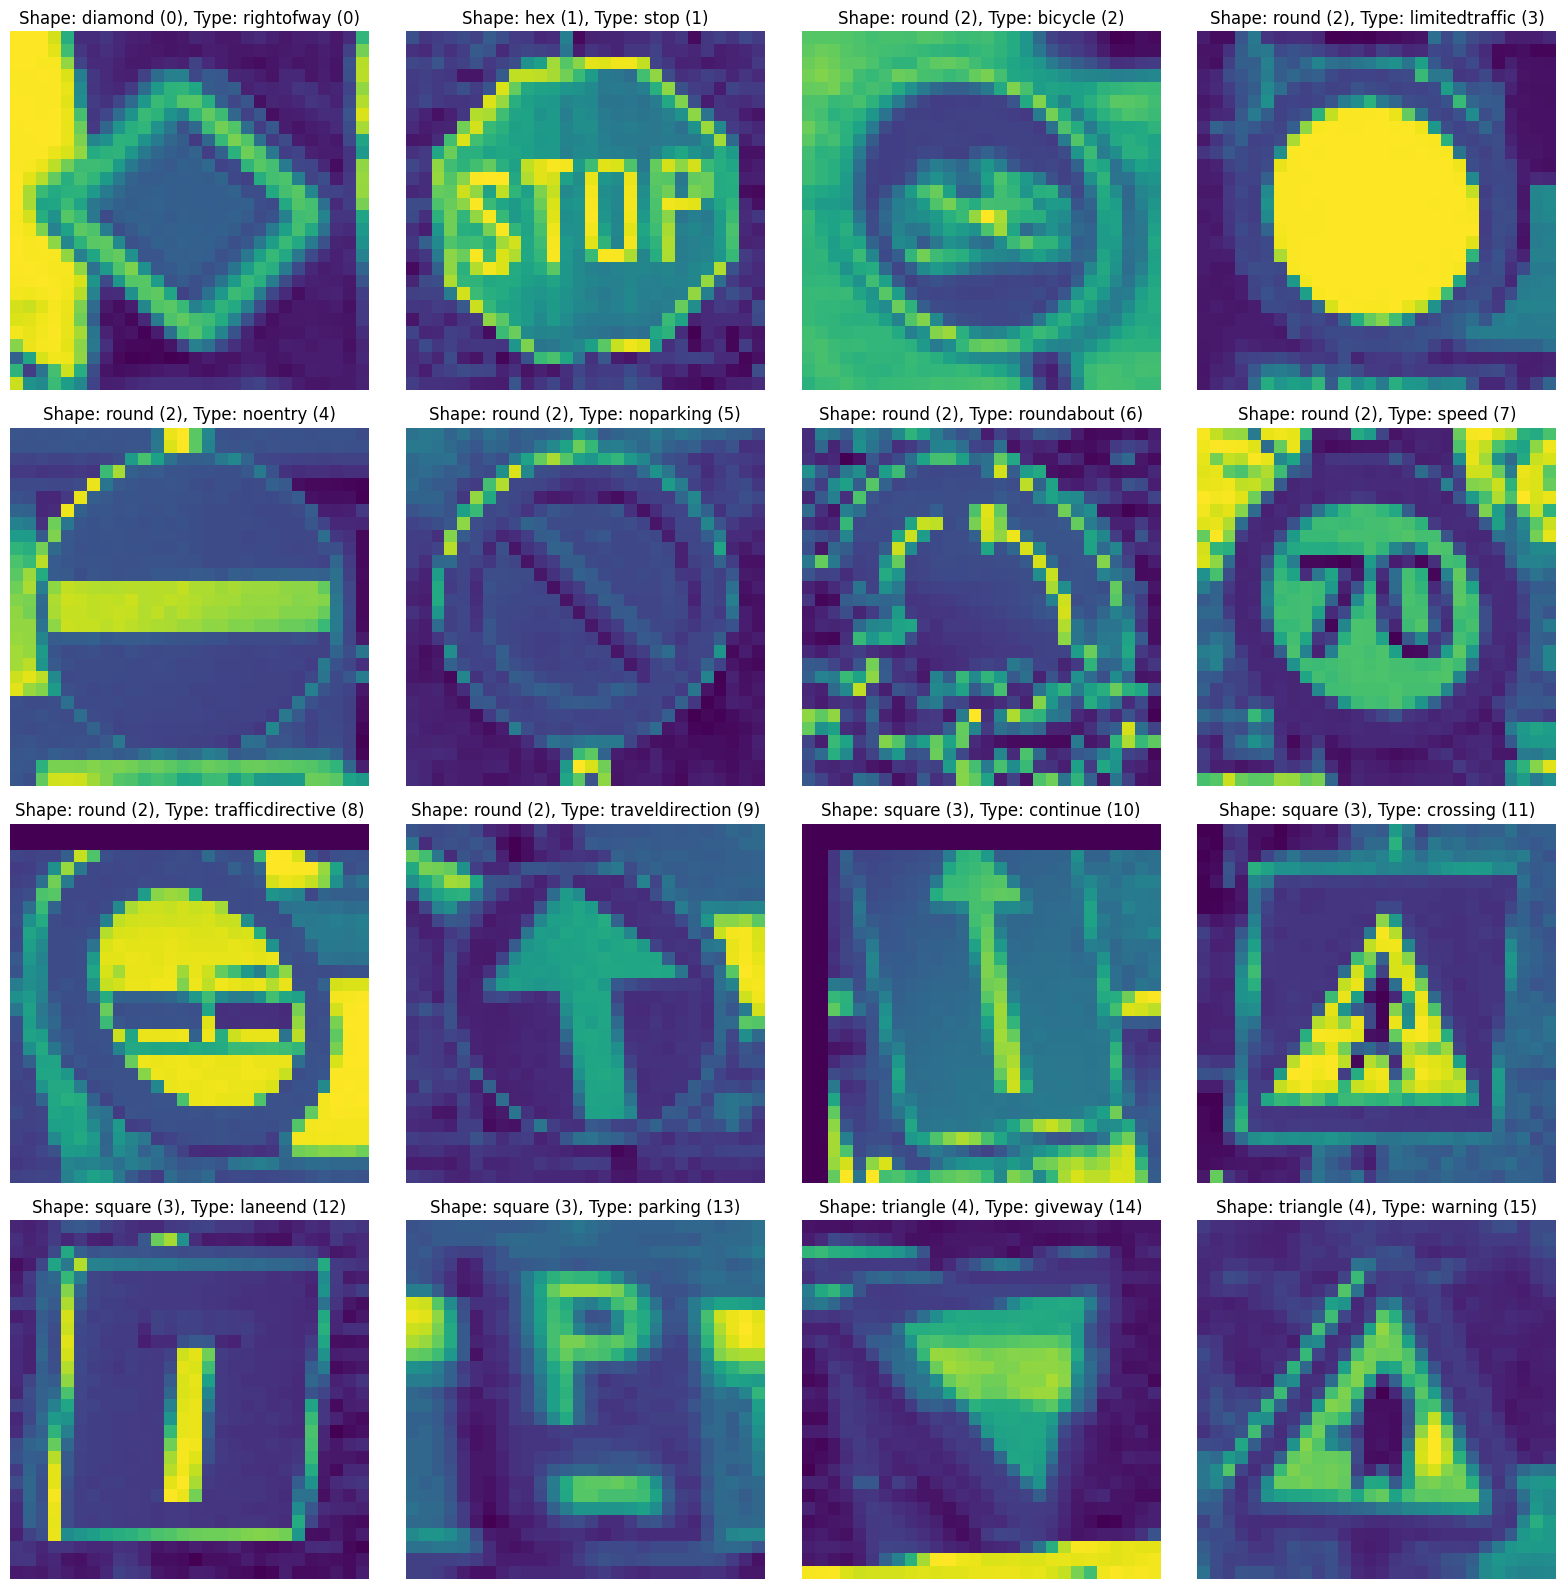

In [15]:
from matplotlib.pyplot import imread
import imageio


df['class_combo'] = df[['shape_label', 'type_label']].apply(tuple, axis=1)

# Reverse dictionaries to map labels back to names
shape_names = {v: k for k, v in trafficsigns_shapes.items()}
type_names = {v: k for k, v in trafficsigns_types.items()}

# Group by this new combo and pick the first image from each group
grouped = df.groupby('class_combo').first().reset_index()

# Visualization
plt.figure(figsize=(16, 16))
for i, row in enumerate(grouped.itertuples(), 1):
    plt.subplot(4, 4, i)  # Adjust grid size based on the number of unique class combinations
    image_path = os.path.join(os.getcwd(), row.image_path)
    image = imread(image_path)
    # Look up the shape and type names using the reverse dictionaries
    shape_name = shape_names.get(row.shape_label, "Unknown")
    type_name = type_names.get(row.type_label, "Unknown")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Shape: {shape_name} ({row.shape_label}), Type: {type_name} ({row.type_label})", fontsize=12)

plt.tight_layout()
plt.show()

## 3.2 Distribution of the dataset

<ipython-input-16-04e344e16c44>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(shape_labels, rotation=45, ha='right')
<ipython-input-16-04e344e16c44>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(type_labels, rotation=45, ha='right')


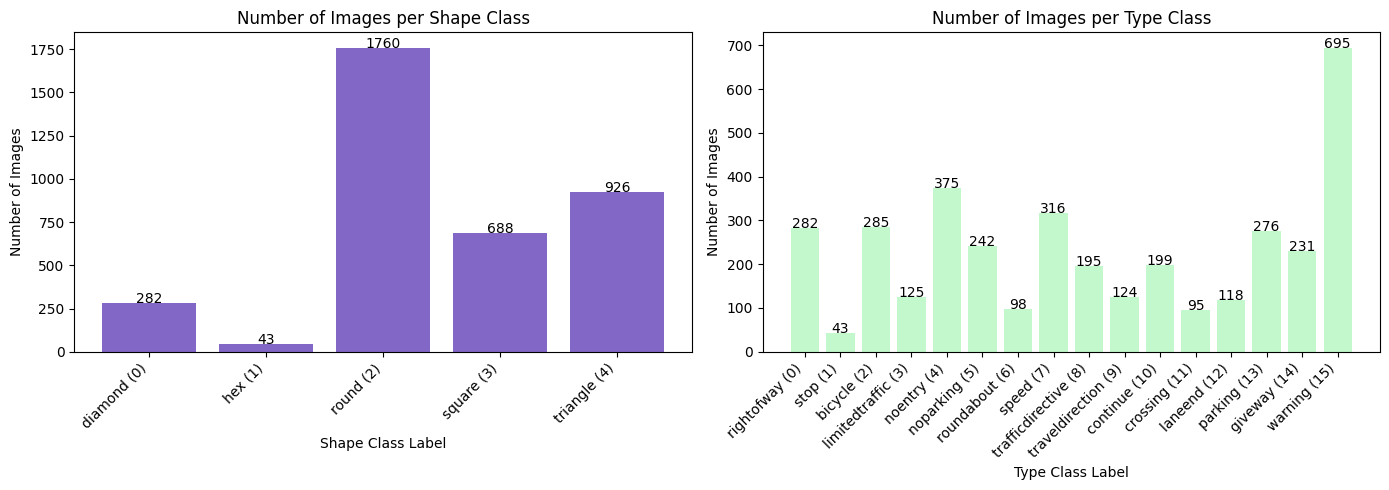

In [16]:
import matplotlib.pyplot as plt


# Convert index to label name for shapes
shape_labels = [f'{k} ({v})' for k, v in sorted(trafficsigns_shapes.items(), key=lambda item: item[1])]
# Convert index to label name for types
type_labels = [f'{k} ({v})' for k, v in sorted(trafficsigns_types.items(), key=lambda item: item[1])]

# Calculate the count of each class label for shape and type
shape_counts = df['shape_label'].value_counts().sort_index()
type_counts = df['type_label'].value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Bar chart for shape labels
axes[0].bar(shape_labels, shape_counts.values, color='#8367c7')
axes[0].set_title('Number of Images per Shape Class')
axes[0].set_xlabel('Shape Class Label')
axes[0].set_ylabel('Number of Images')
axes[0].set_xticklabels(shape_labels, rotation=45, ha='right')
for index, value in enumerate(shape_counts.values):
    axes[0].text(index, value, str(value), ha='center')

# Bar chart for type labels
axes[1].bar(type_labels, type_counts.values, color='#C2F8CB')
axes[1].set_title('Number of Images per Type Class')
axes[1].set_xlabel('Type Class Label')
axes[1].set_ylabel('Number of Images')
axes[1].set_xticklabels(type_labels, rotation=45, ha='right')
for index, value in enumerate(type_counts.values):
    axes[1].text(index, value, str(value), ha='center')

plt.tight_layout()
plt.show()

#### Observations:
- Class imbalance: may affect the model performance. Further actions need to be taken to solve it

## 4. Data Spliting
- split offered dataset into 2 parts.
- Training set: 80%
- Validation set: 20%
- Testing set: 20%
- External test set: the additional dataset

**Constants**

In [17]:
# height = 28 pixel, width = 28 pixel, channel = 1 (Grayscale)
INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM_SHAPE = 128
HIDDEN_LAYER_DIM_TYPE = 256
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES_SHAPE = 5  # Number of shape classes
OUTPUT_CLASSES_TYPE = 16  # Number of type classes

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)
external_test_data = df_test

print("Train data : {}, Val Data: {}, Test Data: {}, External test data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0], external_test_data.shape[0]))


Train data : 2219, Val Data: 740, Test Data: 740, External test data: 2234


In [19]:
train_data.shape

(2219, 4)

In [20]:
# Print column names to verify
print(train_data.columns)

Index(['image_path', 'shape_label', 'type_label', 'class_combo'], dtype='object')


## Solve Class Imbalance with Data Augmentation (SMOTE--Oversampling)

Prepare data

#### Define a function to process images

In [21]:
def get_imgs_array(image_paths):
  images_data = []
  # Load all image
  for img_path in image_paths:
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      images_data.append(img)
  return np.array(images_data)

In [22]:
X = get_imgs_array(train_data['image_path'])


shape_labels_encoded = train_data['shape_label'].values
type_labels_encoded = train_data['type_label'].values

X_reshape = X.reshape(X.shape[0], -1)


Initialize SMOTE

In [23]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

Oversampling for shape labels

In [24]:
X_resampled_shape, y_resampled_shape = smote.fit_resample(X_reshape, shape_labels_encoded)
# X_resampled_shape = X_resampled_shape.reshape(X_resampled_shape.shape[0], *original_image_shape)
num_samples = X_resampled_shape.shape[0]
height = 28
width = 28
channel = 1

X_resampled_shape_reshaped = X_resampled_shape.reshape(num_samples, height, width, channel)

In [25]:
def check_oversampling_classes(resampled_label):
  unique_classes_resampled, counts_resampled = np.unique(resampled_label, return_counts=True)
  print("\nOversampled Class Distribution:")
  for cls, count in zip(unique_classes_resampled, counts_resampled):
      print(f"Class {cls}: {count} samples")

check_oversampling_classes(y_resampled_shape)


Oversampled Class Distribution:
Class 0: 1073 samples
Class 1: 1073 samples
Class 2: 1073 samples
Class 3: 1073 samples
Class 4: 1073 samples


Oversampling for shape and type labels

In [26]:
X_resampled_shape_type, y_resampled_type = smote.fit_resample(X_reshape, type_labels_encoded)
print(X_resampled_shape_type.shape)
num_samples = X_resampled_shape_type.shape[0]

X_resampled_shape_type = X_resampled_shape_type.reshape(num_samples, height, width, channel)

(6592, 784)


In [27]:
check_oversampling_classes(y_resampled_type)


Oversampled Class Distribution:
Class 0: 412 samples
Class 1: 412 samples
Class 2: 412 samples
Class 3: 412 samples
Class 4: 412 samples
Class 5: 412 samples
Class 6: 412 samples
Class 7: 412 samples
Class 8: 412 samples
Class 9: 412 samples
Class 10: 412 samples
Class 11: 412 samples
Class 12: 412 samples
Class 13: 412 samples
Class 14: 412 samples
Class 15: 412 samples


## Prepare data for training models

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 64


##### prepare train data generator

In [29]:
# function to create image generator
def create_img_generator(x, y, class_num):
  y = to_categorical(y, num_classes=class_num)
  return datagen.flow(x=x, y=y, batch_size=batch_size)


train_generator_shape = create_img_generator(x=X_resampled_shape_reshaped, y=y_resampled_shape, class_num=OUTPUT_CLASSES_SHAPE)

train_generator_type = create_img_generator(x=X_resampled_shape_type, y=y_resampled_type, class_num=OUTPUT_CLASSES_TYPE)


In [30]:
# for batch_x, batch_y in train_generator_type:
#     print(np.argmax(batch_y, axis=1))
#     break
y=np.concatenate([np.argmax(train_generator_type.next()[1], axis=1) for i in range(len(train_generator_type))])
print(len(y))

6592


##### prepare validation data generator

In [31]:
def images_for_flow(image_array):
  num_samples = image_array.shape[0]
  return  image_array.reshape(num_samples, 28, 28, 1)

val_x = get_imgs_array(val_data['image_path'])
val_x = images_for_flow(val_x)
val_y_shape = val_data['shape_label']
val_y_type = val_data['type_label']


validation_generator_shape = create_img_generator(x=val_x, y=val_y_shape, class_num=OUTPUT_CLASSES_SHAPE)

validation_generator_type = create_img_generator(x=val_x, y=val_y_type, class_num=OUTPUT_CLASSES_TYPE)


#### Define a function to plot accuracy between validation data and train data

In [128]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='F! Score'):
    print(f"Validation Loss: {val_loss[-1]:.4f}")
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')



#### Install Keras

To build an image classifier we make use of Tensorflow‘ s Keras API to build our model

In [33]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.15.0'

#### Set up the layers
We will use the Sequential API to build models as it is the simplest. In a **Sequential** type, each layer takes the output from the previous layer and uses it as its input.
**Dense** layers in a neural network mean that every node in one layer is connected to all the nodes in the previous layer.

In [34]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 21.6 MB/s eta 0:00:00


## 5.1 Baseline Model - MLP Neural Network (for 2 tasks)




* **What is an MLP?**
  - A type of neural network with three or more layers: input, hidden, and output layers.
  - Fully connected: Each neuron in one layer connects to every neuron in the next layer.
  - Utilizes backpropagation for learning, adjusting weights to minimize output error.
* **Why choose an MLP as a baseline model?**
  - Simplicity: Easy to implement and requires less setup time.
  - Efficiency: Quick to train, providing fast initial results.
  - Low Resource Use: Less computationally intensive than more complex models.
  - Performance Benchmarking: Provides a reference point for evaluating more advanced models.
  - Data Requirements: Performs well with smaller datasets, ideal when large data is unavailable.
  - Interpretability: Simple architecture makes it easier to understand and deb

### **Model1.1 Baseline Model --- Traffic sign shape**

In [35]:
model_shape_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(units=HIDDEN_LAYER_DIM_SHAPE, activation='relu', name='m1_shape_hidden1'),
    tf.keras.layers.Dense(units=64, activation='relu', name='m1_shape_hidden2'),
    tf.keras.layers.Dense(units=16, activation='relu', name='m1_shape_hidden3'),
    tf.keras.layers.Dense(units=OUTPUT_CLASSES_SHAPE, activation='softmax', name='m1_shape_output')
])

model_shape_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy())

In [36]:
model_shape_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 m1_shape_hidden1 (Dense)    (None, 128)               100480    
                                                                 
 m1_shape_hidden2 (Dense)    (None, 64)                8256      
                                                                 
 m1_shape_hidden3 (Dense)    (None, 16)                1040      
                                                                 
 m1_shape_output (Dense)     (None, 5)                 85        
                                                                 
Total params: 109861 (429.14 KB)
Trainable params: 109861 (429.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


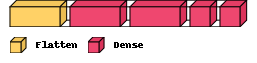

In [37]:
import visualkeras
# Generating the image for model architecture
visualkeras.layered_view(model_shape_1, scale_xy=2, scale_z=1, max_z=50, legend=True)


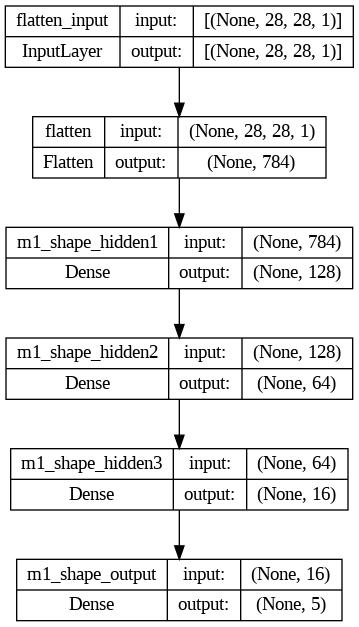

In [38]:
tf.keras.utils.plot_model(model_shape_1, show_shapes=True)


#### Train the base model for shape


train the base model for shape

##### Define a Class to calculate the F1 score during the training model process

In [39]:
class F1ScoreCallback(Callback):
    def __init__(self, model, train_generator, validation_generator):
        super(F1ScoreCallback, self).__init__()
        self.model = model
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.train_f1_scores = []
        self.val_f1_scores = []

    def calculate_f1_score(self, y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro')

    def on_epoch_end(self, epoch, logs=None):
        # Training data
        train_y_true = np.concatenate([np.argmax(self.train_generator[i][1], axis=1) for i in range(len(self.train_generator))])
        train_y_pred = np.argmax(self.model.predict(self.train_generator), axis=1)
        train_f1 = self.calculate_f1_score(train_y_true, train_y_pred)

        # Validation data
        val_y_true = np.concatenate([np.argmax(self.validation_generator[i][1], axis=1) for i in range(len(self.validation_generator))])
        val_y_pred = np.argmax(self.model.predict(self.validation_generator), axis=1)
        val_f1 = self.calculate_f1_score(val_y_true, val_y_pred)

        self.train_f1_scores.append(train_f1)
        self.val_f1_scores.append(val_f1)

        print(f'Epoch {epoch + 1} - Train F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')


In [40]:
# Custom callback instance
f1_score_callback_nn_shape = F1ScoreCallback(model_shape_1, train_generator_shape, validation_generator_shape)

history_1_shape = model_shape_1.fit(train_generator_shape,
                                    validation_data=validation_generator_shape,
                                    epochs=50,
                                    verbose=0,
                                    callbacks=[f1_score_callback_nn_shape])


12/12 [==============================] - 0s 6ms/step
Epoch 1 - Train F1: 0.6435, Validation F1: 0.6448
12/12 [==============================] - 0s 5ms/step
Epoch 2 - Train F1: 0.6482, Validation F1: 0.6946
12/12 [==============================] - 0s 6ms/step
Epoch 3 - Train F1: 0.7880, Validation F1: 0.7447
12/12 [==============================] - 0s 5ms/step
Epoch 4 - Train F1: 0.8536, Validation F1: 0.7766
12/12 [==============================] - 0s 5ms/step
Epoch 5 - Train F1: 0.8844, Validation F1: 0.8321
12/12 [==============================] - 0s 7ms/step
Epoch 6 - Train F1: 0.8886, Validation F1: 0.8870
12/12 [==============================] - 0s 6ms/step
Epoch 7 - Train F1: 0.9212, Validation F1: 0.7947
12/12 [==============================] - 0s 8ms/step
Epoch 8 - Train F1: 0.9332, Validation F1: 0.8277
12/12 [==============================] - 0s 6ms/step
Epoch 9 - Train F1: 0.9810, Validation F1: 0.8991
12/12 [==============================] - 0s 7ms/step
Epoch 10 - Train F1:

Validation Loss: 0.1046


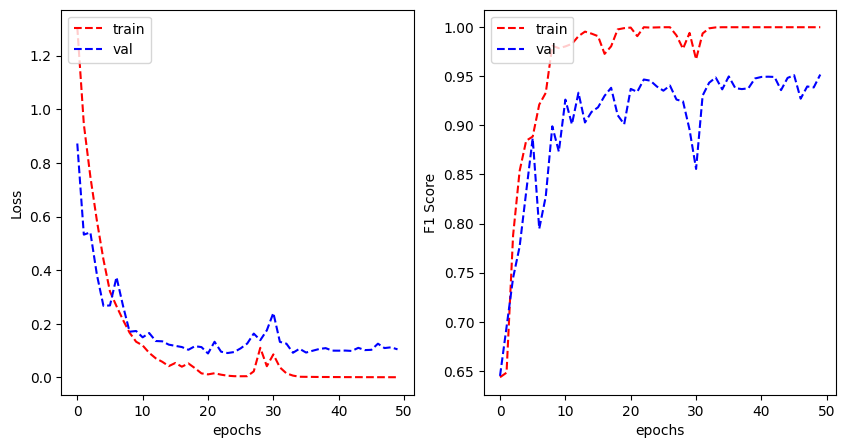

In [130]:
plot_learning_curve(history_1_shape.history['loss'], history_1_shape.history['val_loss'],
                    f1_score_callback_nn_shape.train_f1_scores, f1_score_callback_nn_shape.val_f1_scores,
                    metric_name='F1 Score')

### use test data plot confusion matrix

In [42]:
test_x = get_imgs_array(test_data['image_path'])
test_x = images_for_flow(test_x)
test_y_shape = test_data['shape_label']
test_y_type = test_data['type_label']


test_generator_shape = create_img_generator(x=test_x, y=test_y_shape, class_num=OUTPUT_CLASSES_SHAPE)

test_generator_type = create_img_generator(x=test_x, y=test_y_type, class_num=OUTPUT_CLASSES_TYPE)


### **Model1.2 Baseline Model --- traffic sign type**

In [43]:
model_type_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(units=HIDDEN_LAYER_DIM_TYPE, activation='relu', name='m1_type_hidden1'),
    tf.keras.layers.Dense(units=128, activation='relu', name='m1_type_hidden2'),
    tf.keras.layers.Dense(units=64, activation='relu', name='m1_type_hidden3'),
    tf.keras.layers.Dense(units=OUTPUT_CLASSES_TYPE, activation='softmax', name='m1_output')
])

model_type_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy())

In [44]:
model_type_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 m1_type_hidden1 (Dense)     (None, 256)               200960    
                                                                 
 m1_type_hidden2 (Dense)     (None, 128)               32896     
                                                                 
 m1_type_hidden3 (Dense)     (None, 64)                8256      
                                                                 
 m1_output (Dense)           (None, 16)                1040      
                                                                 
Total params: 243152 (949.81 KB)
Trainable params: 243152 (949.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


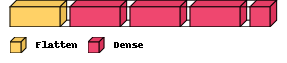

In [45]:
# Generating the image for model architecture
visualkeras.layered_view(model_type_1, scale_xy=2, scale_z=1, max_z=50, legend=True)

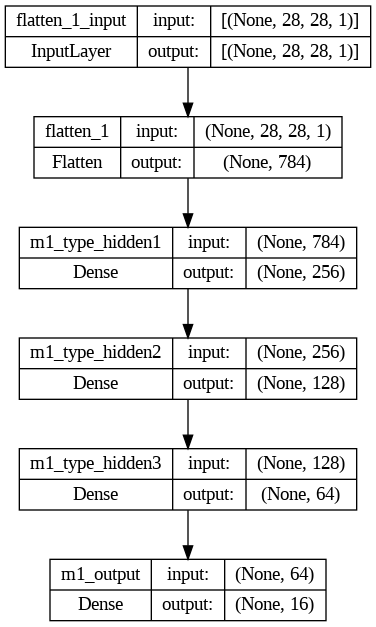

In [46]:
tf.keras.utils.plot_model(model_type_1, show_shapes=True)

### train the base model (type)

In [47]:
# Custom callback instance
f1_score_callback_nn_type = F1ScoreCallback(model_type_1, train_generator_type, validation_generator_type)

history_1_type = model_type_1.fit(train_generator_type,
                                  validation_data = validation_generator_type,
                                  epochs=50,
                                  verbose=0,
                                  callbacks=[f1_score_callback_nn_type])


12/12 [==============================] - 0s 4ms/step
Epoch 1 - Train F1: 0.5435, Validation F1: 0.6289
12/12 [==============================] - 0s 4ms/step
Epoch 2 - Train F1: 0.6710, Validation F1: 0.8052
12/12 [==============================] - 0s 5ms/step
Epoch 3 - Train F1: 0.7556, Validation F1: 0.8814
12/12 [==============================] - 0s 4ms/step
Epoch 4 - Train F1: 0.8002, Validation F1: 0.8723
12/12 [==============================] - 0s 4ms/step
Epoch 5 - Train F1: 0.8431, Validation F1: 0.8921
12/12 [==============================] - 0s 4ms/step
Epoch 6 - Train F1: 0.8423, Validation F1: 0.8729
12/12 [==============================] - 0s 4ms/step
Epoch 7 - Train F1: 0.8337, Validation F1: 0.9114
12/12 [==============================] - 0s 4ms/step
Epoch 8 - Train F1: 0.9121, Validation F1: 0.9341
12/12 [==============================] - 0s 4ms/step
Epoch 9 - Train F1: 0.9111, Validation F1: 0.9226
12/12 [==============================] - 0s 5ms/step
Epoch 10 - Train F1:

Validation Loss: 0.2394


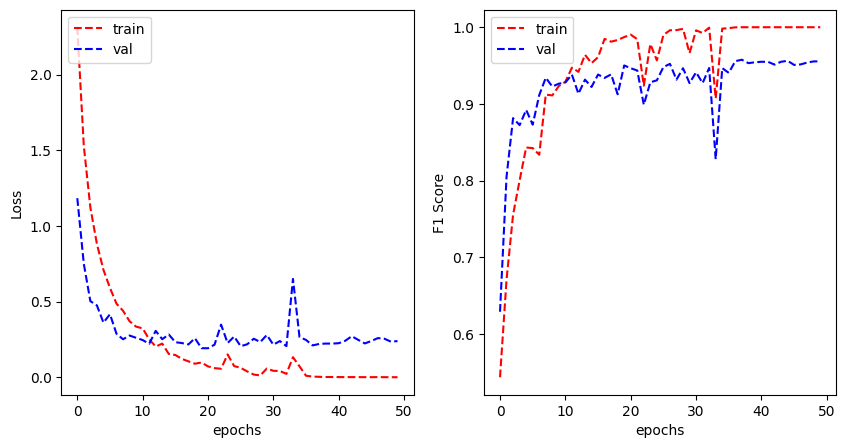

In [129]:
plot_learning_curve(history_1_type.history['loss'], history_1_type.history['val_loss'],
                    f1_score_callback_nn_type.train_f1_scores, f1_score_callback_nn_type.val_f1_scores,
                    metric_name='F1 Score')


Observations:



In [133]:
def plot_combined_learning_curve(shape_history, type_history, shape_f1_score_callback, type__f1_score_callback, metric_name='F1 Score'):
    epochs = range(1, len(shape_history['loss']) + 1)

    plt.figure(figsize=(14, 8))

    # Plot training and validation loss for shape and type
    plt.subplot(1, 2, 1)
    plt.plot(epochs, shape_history['loss'], 'b-', label='Shape Training Loss')
    plt.plot(epochs, shape_history['val_loss'], 'b--', label='Shape Validation Loss')
    plt.plot(epochs, type_history['loss'], 'r-', label='Type Training Loss')
    plt.plot(epochs, type_history['val_loss'], 'r--', label='Type Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training and validation accuracy for shape and type
    plt.subplot(1, 2, 2)
    plt.plot(epochs, shape_f1_score_callback.train_f1_scores, 'b-', label='Shape Training F1 Score')
    plt.plot(epochs, shape_f1_score_callback.val_f1_scores, 'b--', label='Shape Validation F1 Score')
    plt.plot(epochs, type__f1_score_callback.train_f1_scores, 'r-', label='Type Training F1 Score')
    plt.plot(epochs, type__f1_score_callback.val_f1_scores, 'r--', label='Type Validation F1 Score')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

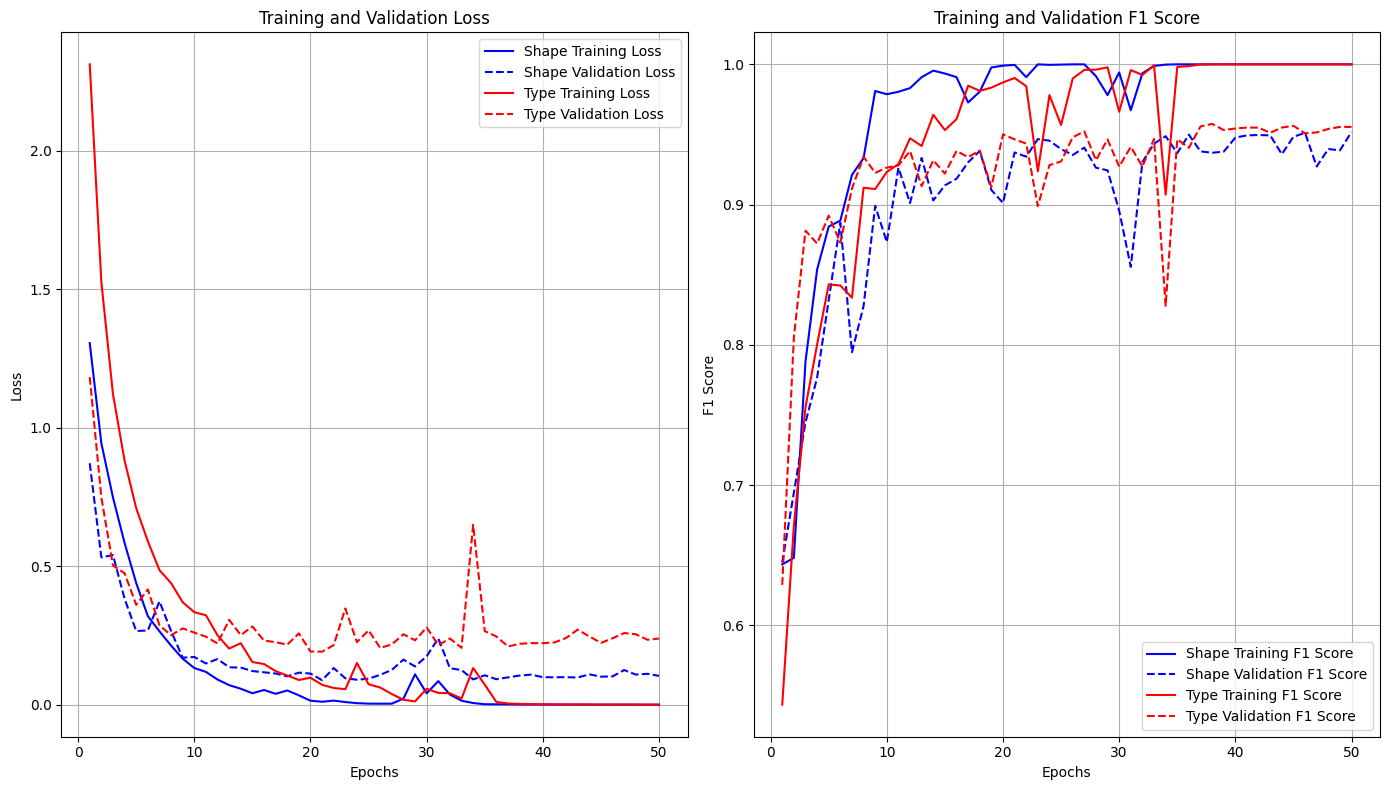

In [134]:
plot_combined_learning_curve(history_1_shape.history, history_1_type.history, f1_score_callback_nn_shape, f1_score_callback_nn_type)

# Model 2 Transfer to CNN model
- replacing the Flatten layer with convolutional (Conv2D) and pooling (MaxPooling2D) layers.

#### 1. model to classify shape


In [51]:
model_shape_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM, name='conv1'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool1'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool2'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(64, activation='relu', name='dense1'),
    tf.keras.layers.Dense(16, activation='relu', name='dense2'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='softmax', name='output')
])

model_shape_2.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy())


In [52]:
model_shape_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense1 (Dense)              (None, 64)               

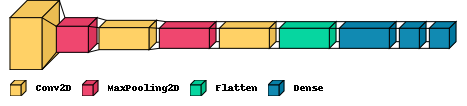

In [53]:
visualkeras.layered_view(model_shape_2, scale_xy=2, scale_z=1, max_z=50, legend=True)

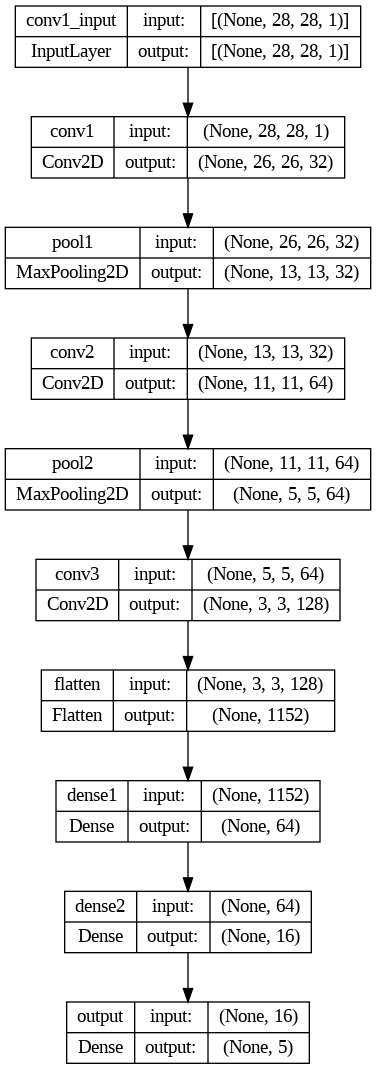

In [54]:
tf.keras.utils.plot_model(model_shape_2, show_shapes=True)

### Fit the model

In [55]:
# Custom callback instance
f1_score_callback_cnn_shape = F1ScoreCallback(model_shape_2, train_generator_shape, validation_generator_shape)

history_2_shape = model_shape_2.fit(train_generator_shape,
                                    validation_data = validation_generator_shape,
                                    epochs=50,
                                    verbose=0,
                                    callbacks=[f1_score_callback_cnn_shape])

12/12 [==============================] - 0s 4ms/step
Epoch 1 - Train F1: 0.8043, Validation F1: 0.7882
12/12 [==============================] - 0s 4ms/step
Epoch 2 - Train F1: 0.9058, Validation F1: 0.8980
12/12 [==============================] - 0s 6ms/step
Epoch 3 - Train F1: 0.9310, Validation F1: 0.9098
12/12 [==============================] - 0s 5ms/step
Epoch 4 - Train F1: 0.9786, Validation F1: 0.9490
12/12 [==============================] - 0s 4ms/step
Epoch 5 - Train F1: 0.9890, Validation F1: 0.9636
12/12 [==============================] - 0s 4ms/step
Epoch 6 - Train F1: 0.9925, Validation F1: 0.9598
12/12 [==============================] - 0s 4ms/step
Epoch 7 - Train F1: 0.9963, Validation F1: 0.9635
12/12 [==============================] - 0s 5ms/step
Epoch 8 - Train F1: 0.9935, Validation F1: 0.9092
12/12 [==============================] - 0s 4ms/step
Epoch 9 - Train F1: 0.9991, Validation F1: 0.9577
12/12 [==============================] - 0s 4ms/step
Epoch 10 - Train F1:

Validation Loss: 0.0621


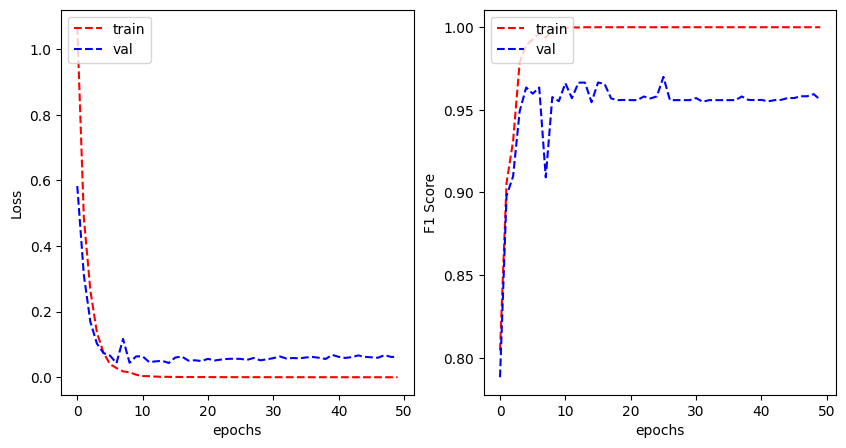

In [135]:
plot_learning_curve(history_2_shape.history['loss'], history_2_shape.history['val_loss'],
                    f1_score_callback_cnn_shape.train_f1_scores, f1_score_callback_cnn_shape.val_f1_scores,
                    metric_name='F1 Score')

In [57]:
model_shape_2.evaluate(test_generator_shape)

12/12 [==============================] - 0s 5ms/step - loss: 0.0350


0.03498595580458641

#### 2. model to classify types

In [58]:
model_type_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM, name='conv1'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool1'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool2'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(128, activation='relu', name='dense1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense2'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation='softmax', name='output')
])

model_type_2.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy())

In [59]:
model_type_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense1 (Dense)              (None, 128)              

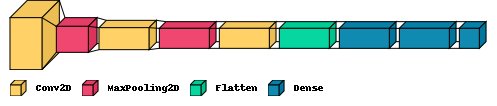

In [60]:
visualkeras.layered_view(model_type_2, scale_xy=2, scale_z=1, max_z=50, legend=True)

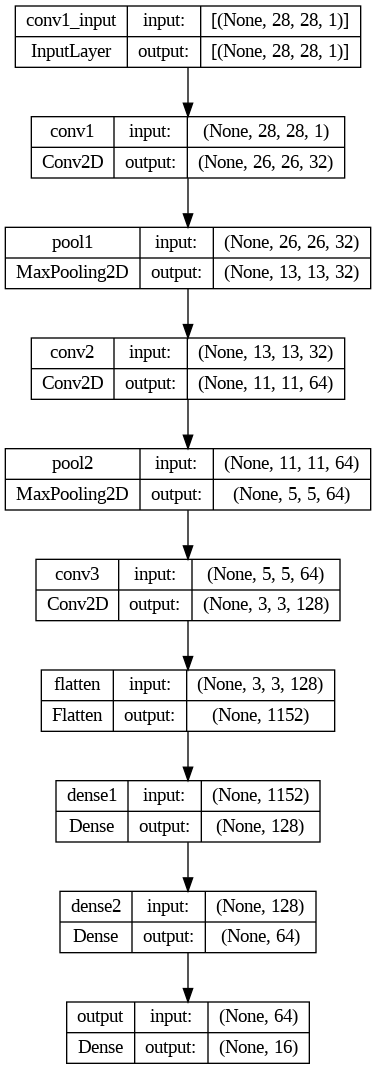

In [61]:
tf.keras.utils.plot_model(model_type_2, show_shapes=True)

##### fit the model

In [62]:
# Custom callback instance
f1_score_callback_cnn_type = F1ScoreCallback(model_type_2, train_generator_type, validation_generator_type)

history_2_type = model_type_2.fit(train_generator_type,
                                  validation_data = validation_generator_type,
                                  epochs=50,
                                  verbose=0,
                                  callbacks=[f1_score_callback_cnn_type])

12/12 [==============================] - 0s 5ms/step
Epoch 1 - Train F1: 0.6718, Validation F1: 0.7414
12/12 [==============================] - 0s 4ms/step
Epoch 2 - Train F1: 0.8184, Validation F1: 0.9074
12/12 [==============================] - 0s 4ms/step
Epoch 3 - Train F1: 0.8650, Validation F1: 0.9170
12/12 [==============================] - 0s 4ms/step
Epoch 4 - Train F1: 0.9082, Validation F1: 0.9322
12/12 [==============================] - 0s 5ms/step
Epoch 5 - Train F1: 0.9461, Validation F1: 0.9538
12/12 [==============================] - 0s 5ms/step
Epoch 6 - Train F1: 0.9643, Validation F1: 0.9600
12/12 [==============================] - 0s 4ms/step
Epoch 7 - Train F1: 0.9629, Validation F1: 0.9645
12/12 [==============================] - 0s 5ms/step
Epoch 8 - Train F1: 0.9688, Validation F1: 0.9527
12/12 [==============================] - 0s 5ms/step
Epoch 9 - Train F1: 0.9840, Validation F1: 0.9593
12/12 [==============================] - 0s 4ms/step
Epoch 10 - Train F1:

Validation Loss: 0.2019


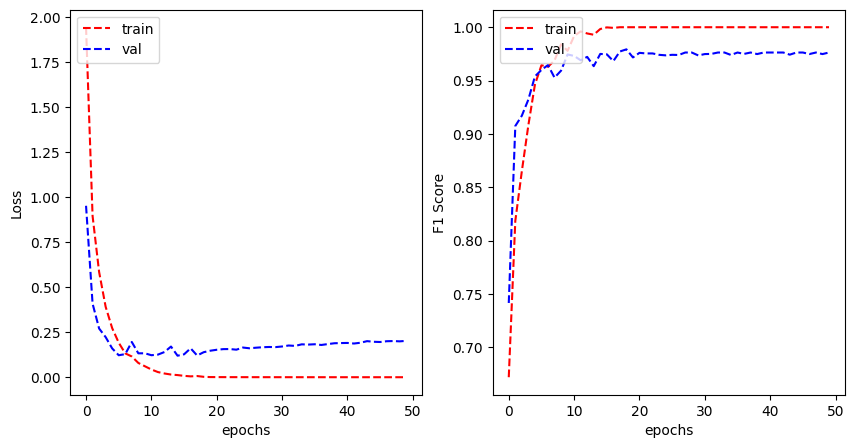

In [136]:
plot_learning_curve(history_2_type.history['loss'], history_2_type.history['val_loss'],
                    f1_score_callback_cnn_type.train_f1_scores, f1_score_callback_cnn_type.val_f1_scores,
                    metric_name='F1 Score')

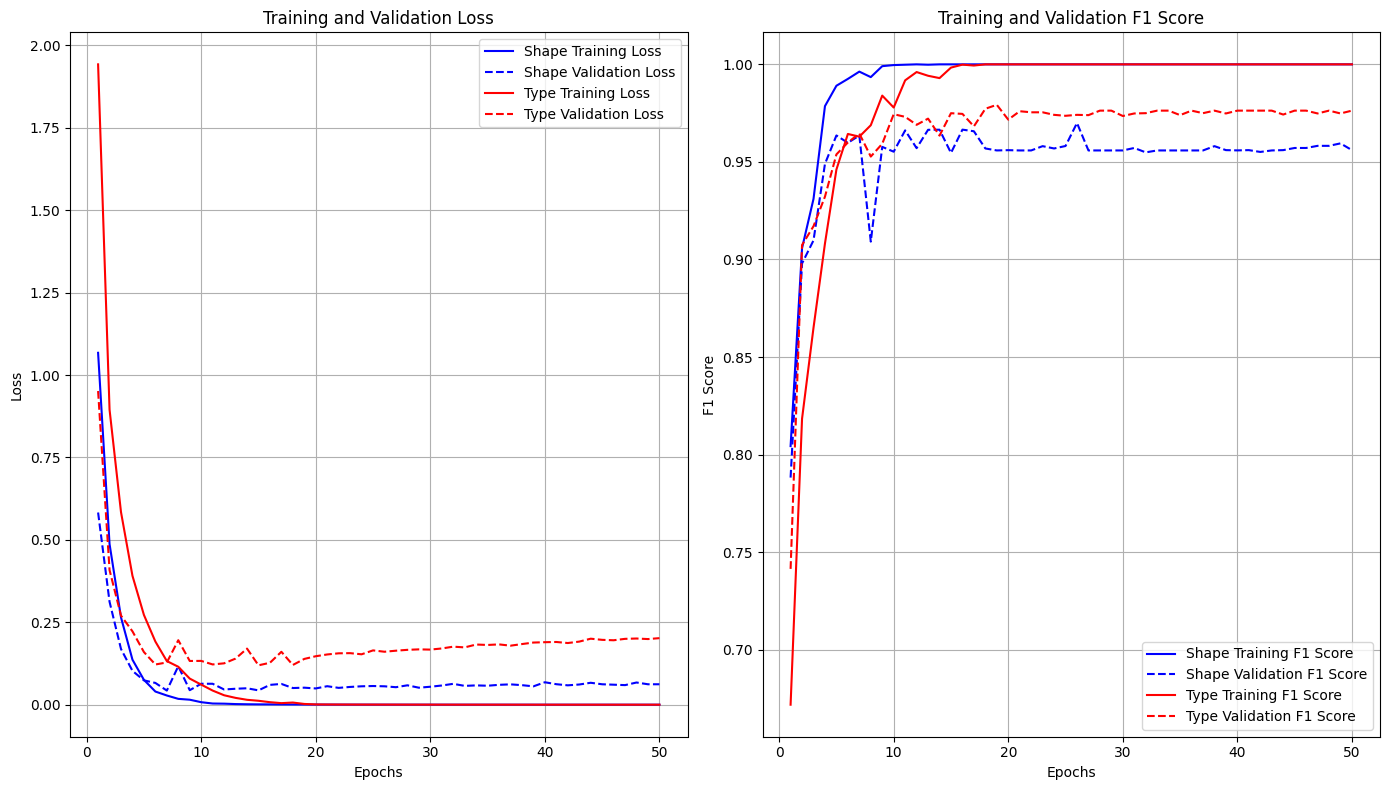

In [137]:

plot_combined_learning_curve(history_2_shape.history, history_2_type.history, f1_score_callback_cnn_shape, f1_score_callback_cnn_type)


# 5.2 Advanced Model: CNN model


CNNs are better suited for tasks like image recognition because they can exploit the spatial structure of the data through convolutional layers, reducing the number of parameters needed compared to fully connected layers in MLPs, making them more efficient and effective for tasks with spatial relationships, like images.



# VGG

The VGG architecture enhances basic CNNs through:
1. Uniformity: It consistently uses 3×3 convolutional filters and 2×2 max pooling, facilitating deeper network construction.
2. Depth: Deeper layers in VGG allow for more complex feature learning, improving image classification performance.
3. Robust Training: Strong initialisation, regularisation, and augmentation strategies improve training and prevent overfitting.



### Model 2.1 Shape classification using VGG CNN


In [65]:
model_VGG_1 = tf.keras.Sequential([
    # VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='softmax'),
])

In [66]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy())

In [67]:
model_VGG_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                 

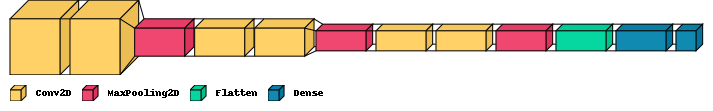

In [68]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_1, scale_xy=2, scale_z=1, max_z=50, legend=True)

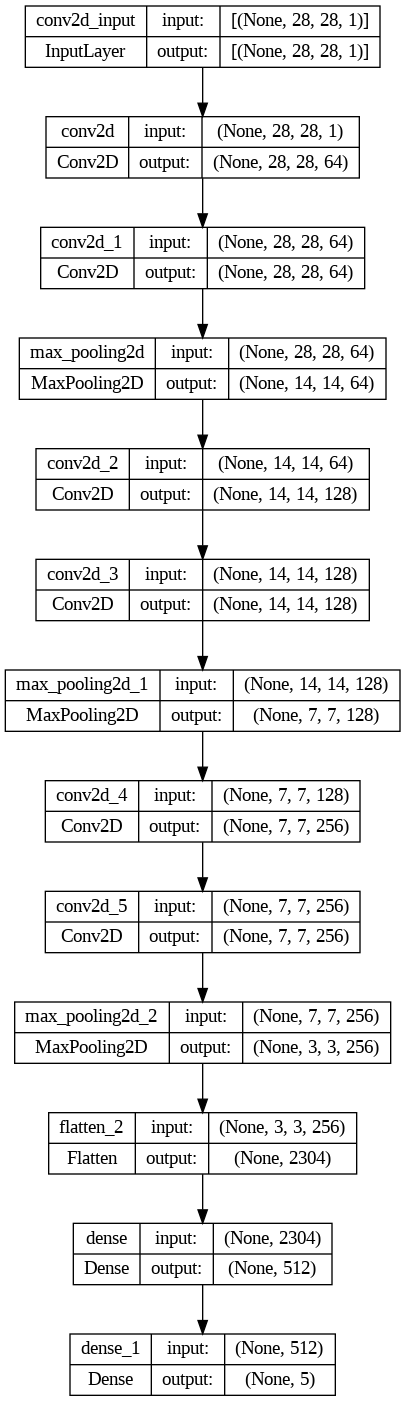

In [69]:
tf.keras.utils.plot_model(model_VGG_1, show_shapes=True)

Fit the model

In [70]:
# Custom callback instance
f1_score_callback_vgg_shape = F1ScoreCallback(model_VGG_1, train_generator_shape, validation_generator_shape)

history_VGG_1 = model_VGG_1.fit(
    train_generator_shape,
    validation_data=validation_generator_shape,
    epochs=50,
    verbose=0,
    callbacks=[f1_score_callback_vgg_shape]
)

12/12 [==============================] - 0s 5ms/step
Epoch 1 - Train F1: 0.8737, Validation F1: 0.8088
12/12 [==============================] - 0s 5ms/step
Epoch 2 - Train F1: 0.9695, Validation F1: 0.9462
12/12 [==============================] - 0s 7ms/step
Epoch 3 - Train F1: 0.9933, Validation F1: 0.9645
12/12 [==============================] - 0s 7ms/step
Epoch 4 - Train F1: 0.9888, Validation F1: 0.9398
12/12 [==============================] - 0s 4ms/step
Epoch 5 - Train F1: 0.9907, Validation F1: 0.9767
12/12 [==============================] - 0s 5ms/step
Epoch 6 - Train F1: 0.9979, Validation F1: 0.9601
12/12 [==============================] - 0s 4ms/step
Epoch 7 - Train F1: 0.9912, Validation F1: 0.9225
12/12 [==============================] - 0s 6ms/step
Epoch 8 - Train F1: 0.9937, Validation F1: 0.9669
12/12 [==============================] - 0s 7ms/step
Epoch 9 - Train F1: 0.9993, Validation F1: 0.9790
12/12 [==============================] - 0s 5ms/step
Epoch 10 - Train F1:

Validation Loss: 0.0298


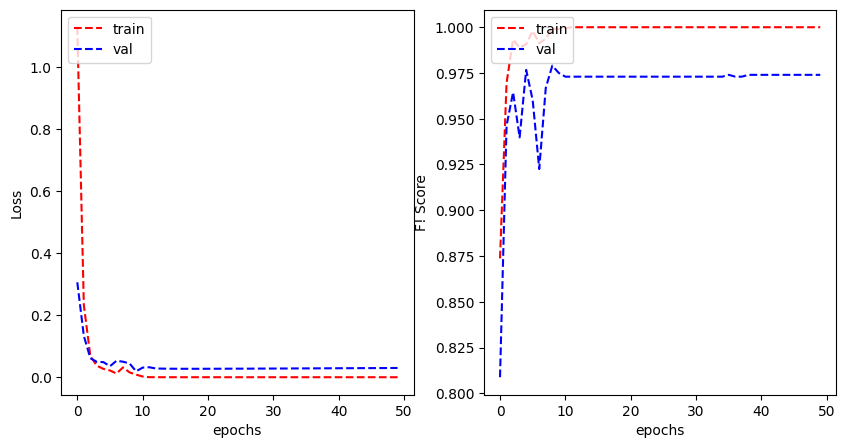

In [138]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'],
                    f1_score_callback_vgg_shape.train_f1_scores, f1_score_callback_vgg_shape.val_f1_scores)

In [72]:
model_VGG_1.evaluate(test_generator_shape)

12/12 [==============================] - 0s 7ms/step - loss: 0.0571


0.057081300765275955

### Add Normalisation and Dropout layers


Justification for Adding Batch Normalization and Dropout:
* Batch Normalization: Stabilizes and accelerates training, allows higher learning rates, and reduces sensitivity to weight initialization.
* Dropout: Prevents overfitting and improves generalization by randomly setting a fraction of input units to zero during training.

These additions enhance model stability, speed, and performance on unseen data.

### Hyperparameter tuning

Tune dropout rate and L2 to get the best performance model

In [73]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

def create_model(l2_reg=0.001, dropout_rate=0.3):
    model = Sequential([
        # VGG block 1
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, kernel_regularizer=l2(l2_reg)),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # VGG block 2
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # VGG block 3
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(OUTPUT_CLASSES_SHAPE, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy')
    return model

# Example of different L2 and dropout rates to test
l2_regs = [0.00001, 0.0001, 0.001, 0.01]
dropout_rates = [0.2, 0.3, 0.4, 0.5]

results = {}

for l2_reg in l2_regs:
    for dropout_rate in dropout_rates:
        print(f'Training with L2={l2_reg} and Dropout={dropout_rate}')
        model = create_model(l2_reg, dropout_rate)
        f1_score_callback = F1ScoreCallback(model, train_generator_shape, validation_generator_shape)

        history = model.fit(train_generator_shape,
                            validation_data=validation_generator_shape,
                            epochs=25,  # Use fewer epochs for quicker experimentation
                            verbose=1,
                            callbacks=[f1_score_callback])

        val_f1 = f1_score_callback.val_f1_scores[-1]
        val_loss = history.history['val_loss'][-1]
        results[(l2_reg, dropout_rate)] = (val_f1, val_loss)

# Print results
for params, (val_f1, val_loss) in results.items():
    print(f'L2={params[0]}, Dropout={params[1]} - Validation F1: {val_f1}, Validation Loss: {val_loss}')


Training with L2=1e-05 and Dropout=0.2
Epoch 1/25
12/12 [==============================] - 0s 5ms/step
Epoch 1 - Train F1: 0.2047, Validation F1: 0.2258
84/84 [==============================] - 8s 29ms/step - loss: 0.4397 - val_loss: 1.6505
Epoch 2/25
12/12 [==============================] - 0s 5ms/step
Epoch 2 - Train F1: 0.0667, Validation F1: 0.0801
84/84 [==============================] - 2s 28ms/step - loss: 0.0760 - val_loss: 2.9307
Epoch 3/25
12/12 [==============================] - 0s 4ms/step
Epoch 3 - Train F1: 0.3774, Validation F1: 0.4358
84/84 [==============================] - 2s 24ms/step - loss: 0.0344 - val_loss: 2.3696
Epoch 4/25
12/12 [==============================] - 0s 5ms/step
Epoch 4 - Train F1: 0.4829, Validation F1: 0.5458
84/84 [==============================] - 2s 23ms/step - loss: 0.0278 - val_loss: 1.6000
Epoch 5/25
12/12 [==============================] - 0s 5ms/step
Epoch 5 - Train F1: 0.7082, Validation F1: 0.7830
84/84 [==============================] 

* The combination of L2=0.0001 and Dropout=0.4 provides the best balance of regularization and dropout due to its **Highest Validation Accuracy and Low Validation Loss**, leading to excellent generalization performance on the validation set. This combination effectively mitigates overfitting while maintaining high accuracy, making it the optimal choice among the tested configurations.
We can see that this combination gives the best

In [104]:
import tensorflow as tf

# Improved VGG-like CNN model for shape classification with added regularization
model_VGG_1_improved = tf.keras.Sequential([
    # VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='softmax'),
])


In [106]:
model_VGG_1_improved.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy())

In [107]:
model_VGG_1_improved.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_216 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_217 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_108 (MaxPool  (None, 14, 14, 64)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_136 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 conv2d_218 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_219 (Conv2D)         (None, 14, 14, 128)     

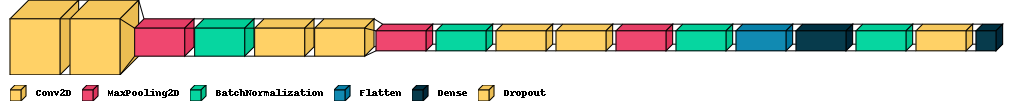

In [108]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_1_improved, scale_xy=2, scale_z=1, max_z=50, legend=True)

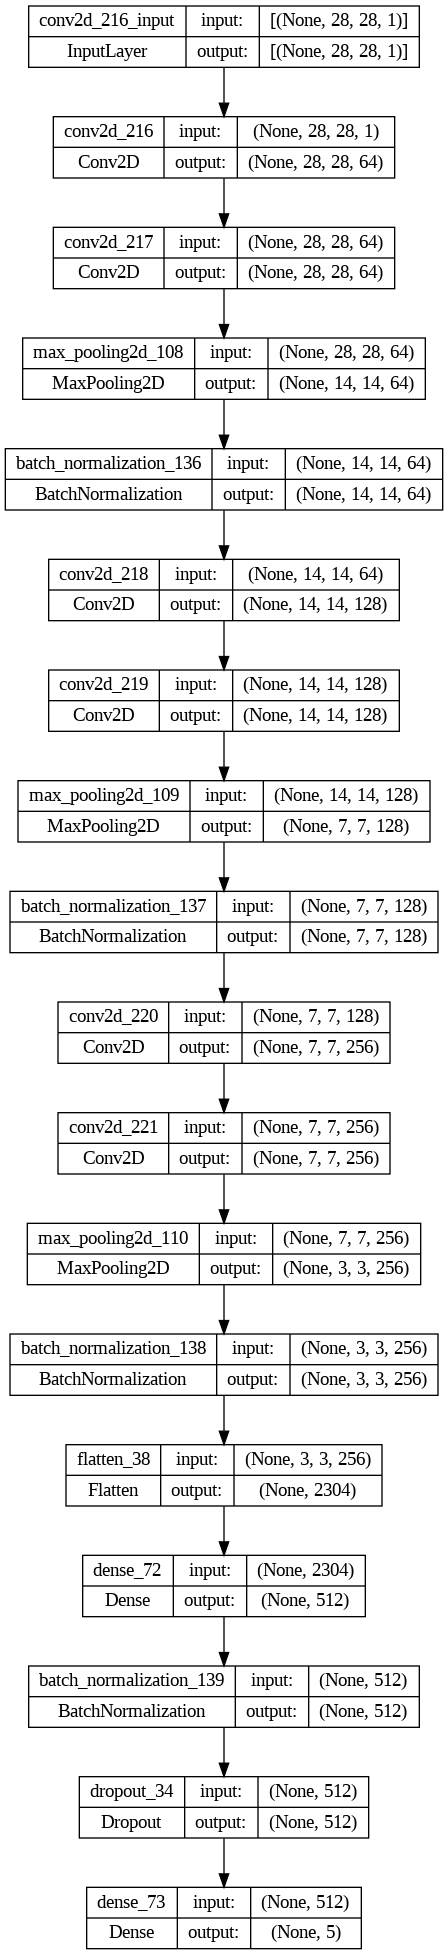

In [109]:
tf.keras.utils.plot_model(model_VGG_1_improved, show_shapes=True)

Fit the model

In [111]:
f1_score_callback_vgg_shape_improved = F1ScoreCallback(model_VGG_1_improved, train_generator_shape, validation_generator_shape)

history_VGG_1_improved = model_VGG_1_improved.fit(
    train_generator_shape,
    validation_data=validation_generator_shape,
    epochs=50,
    verbose=0,
    callbacks=[f1_score_callback_vgg_shape_improved]
)

12/12 [==============================] - 0s 5ms/step
Epoch 1 - Train F1: 0.9994, Validation F1: 0.9879
12/12 [==============================] - 0s 4ms/step
Epoch 2 - Train F1: 0.9959, Validation F1: 0.9840
12/12 [==============================] - 0s 5ms/step
Epoch 3 - Train F1: 0.9779, Validation F1: 0.9627
12/12 [==============================] - 0s 5ms/step
Epoch 4 - Train F1: 0.9924, Validation F1: 0.9045
12/12 [==============================] - 0s 7ms/step
Epoch 5 - Train F1: 0.9940, Validation F1: 0.9892
12/12 [==============================] - 0s 5ms/step
Epoch 6 - Train F1: 0.9983, Validation F1: 0.9648
12/12 [==============================] - 0s 5ms/step
Epoch 7 - Train F1: 0.9996, Validation F1: 0.9732
12/12 [==============================] - 0s 4ms/step
Epoch 8 - Train F1: 0.9978, Validation F1: 0.9955
12/12 [==============================] - 0s 4ms/step
Epoch 9 - Train F1: 0.9996, Validation F1: 0.9758
12/12 [==============================] - 0s 6ms/step
Epoch 10 - Train F1:

Validation Loss: 0.1237


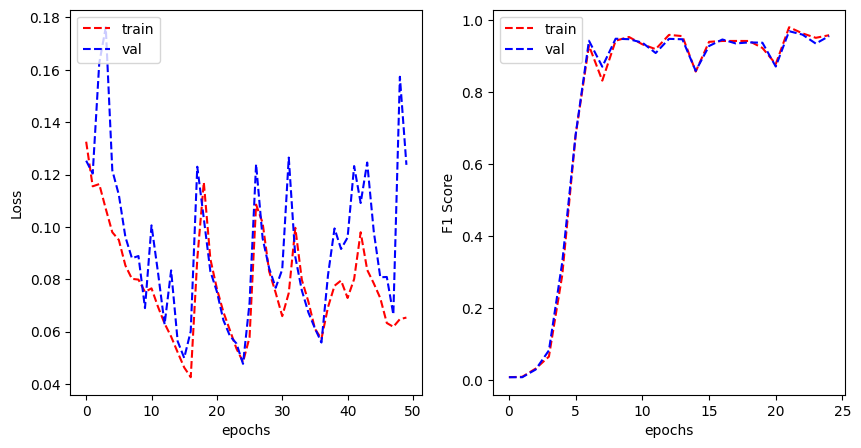

In [139]:
plot_learning_curve(history_VGG_1_improved.history['loss'],
                    history_VGG_1_improved.history['val_loss'],
                    f1_score_callback.train_f1_scores,
                    f1_score_callback.val_f1_scores,
                    metric_name='F1 Score')

In [113]:
model_VGG_1_improved.evaluate(test_generator_shape)

12/12 [==============================] - 0s 7ms/step - loss: 0.1316


0.131582111120224

### Model 2.2 Type classification using VGG CNN


In [114]:
model_VGG_2 = tf.keras.Sequential([
    # VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation='softmax'),
])

In [83]:
model_VGG_2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_109 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_110 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_111 (Conv2D)         (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                               

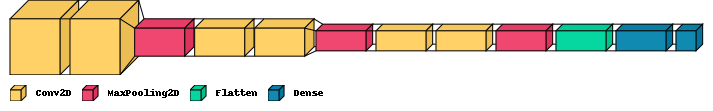

In [84]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_2, scale_xy=2, scale_z=1, max_z=50, legend=True)

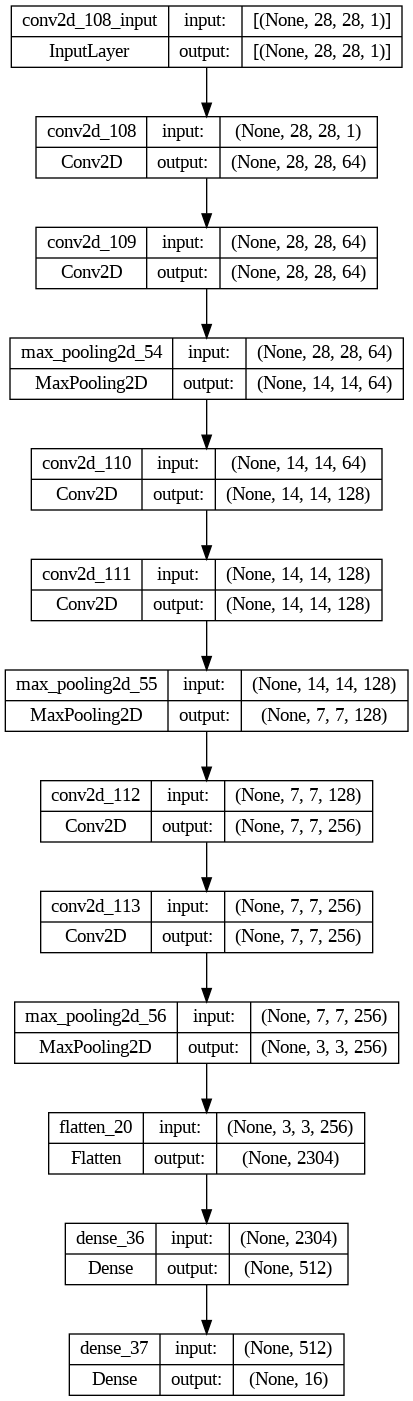

In [85]:
tf.keras.utils.plot_model(model_VGG_2, show_shapes=True)

In [86]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [87]:
# Custom callback instance
f1_score_callback_vgg_type = F1ScoreCallback(model_VGG_2, train_generator_type, validation_generator_type)

history_VGG_2 = model_VGG_2.fit(
    train_generator_type,
    validation_data=validation_generator_type,
    epochs=50,
    verbose=0,
    callbacks=[f1_score_callback_vgg_type]
)

12/12 [==============================] - 0s 4ms/step
Epoch 1 - Train F1: 0.7467, Validation F1: 0.7918
12/12 [==============================] - 0s 4ms/step
Epoch 2 - Train F1: 0.8715, Validation F1: 0.9259
12/12 [==============================] - 0s 6ms/step
Epoch 3 - Train F1: 0.9352, Validation F1: 0.9481
12/12 [==============================] - 0s 4ms/step
Epoch 4 - Train F1: 0.9797, Validation F1: 0.9682
12/12 [==============================] - 0s 5ms/step
Epoch 5 - Train F1: 0.9785, Validation F1: 0.9658
12/12 [==============================] - 0s 5ms/step
Epoch 6 - Train F1: 0.9821, Validation F1: 0.9660
12/12 [==============================] - 0s 7ms/step
Epoch 7 - Train F1: 0.9823, Validation F1: 0.9581
12/12 [==============================] - 0s 4ms/step
Epoch 8 - Train F1: 0.9933, Validation F1: 0.9673
12/12 [==============================] - 0s 4ms/step
Epoch 9 - Train F1: 0.9900, Validation F1: 0.9685
12/12 [==============================] - 0s 4ms/step
Epoch 10 - Train F1:

Validation Loss: 0.1452


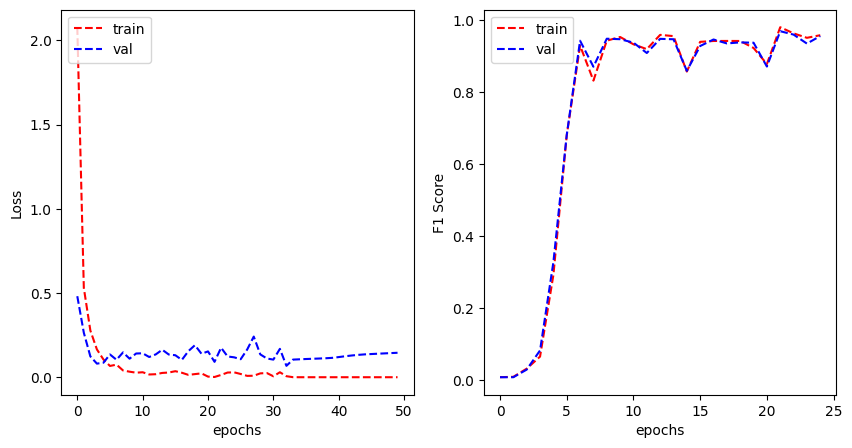

In [140]:
plot_learning_curve(history_VGG_2.history['loss'],
                    history_VGG_2.history['val_loss'],
                    f1_score_callback.train_f1_scores,
                    f1_score_callback.val_f1_scores,
                    metric_name='F1 Score')

In [89]:
model_VGG_2.evaluate(test_generator_type)

12/12 [==============================] - 0s 8ms/step - loss: 0.1210 - categorical_accuracy: 0.9892


[0.12099740654230118, 0.9891892075538635]

### Add Normalisation and Dropout layers

In [90]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

def create_model(l2_reg=0.001, dropout_rate=0.3):
    model = Sequential([
        # VGG block 1
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, kernel_regularizer=l2(l2_reg)),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # VGG block 2
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        # VGG block 3
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(OUTPUT_CLASSES_TYPE, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy')
    return model

# Example of different L2 and dropout rates to test
l2_regs = [0.00001, 0.0001, 0.001, 0.01]
dropout_rates = [0.2, 0.3, 0.4, 0.5]

results = {}

for l2_reg in l2_regs:
    for dropout_rate in dropout_rates:
        print(f'Training with L2={l2_reg} and Dropout={dropout_rate}')
        model = create_model(l2_reg, dropout_rate)
        f1_score_callback = F1ScoreCallback(model, train_generator_type, validation_generator_type)

        history = model.fit(train_generator_type,
                            validation_data=validation_generator_type,
                            epochs=25,  # Use fewer epochs for quicker experimentation
                            verbose=1,
                            callbacks=[f1_score_callback])

        val_f1 = f1_score_callback.val_f1_scores[-1]
        val_loss = history.history['val_loss'][-1]
        results[(l2_reg, dropout_rate)] = (val_f1, val_loss)

# Print results
for params, (val_f1, val_loss) in results.items():
    print(f'L2={params[0]}, Dropout={params[1]} - Validation F1: {val_f1}, Validation Loss: {val_loss}')


Training with L2=1e-05 and Dropout=0.2
Epoch 1/25
12/12 [==============================] - 0s 4ms/step
Epoch 1 - Train F1: 0.0074, Validation F1: 0.0072
103/103 [==============================] - 7s 27ms/step - loss: 0.9195 - val_loss: 3.4958
Epoch 2/25
12/12 [==============================] - 0s 4ms/step
Epoch 2 - Train F1: 0.0074, Validation F1: 0.0072
103/103 [==============================] - 2s 23ms/step - loss: 0.1765 - val_loss: 7.2610
Epoch 3/25
12/12 [==============================] - 0s 5ms/step
Epoch 3 - Train F1: 0.2705, Validation F1: 0.3096
103/103 [==============================] - 2s 23ms/step - loss: 0.0803 - val_loss: 2.0586
Epoch 4/25
12/12 [==============================] - 0s 8ms/step
Epoch 4 - Train F1: 0.7615, Validation F1: 0.8162
103/103 [==============================] - 3s 30ms/step - loss: 0.0360 - val_loss: 0.4371
Epoch 5/25
12/12 [==============================] - 0s 8ms/step
Epoch 5 - Train F1: 0.8841, Validation F1: 0.9144
103/103 [======================

* The combination of L2=0.0001 and Dropout=0.3 provides the best balance of regularization and dropout due to its **Highest Validation Accuracy and Low Validation Loss**, leading to excellent generalization performance on the validation set. This combination effectively mitigates overfitting while maintaining high accuracy, making it the optimal choice among the tested configurations.
We can see that this combination gives the best

In [115]:
import tensorflow as tf

# Improved VGG-like CNN model for shape classification with added regularization
model_VGG_2_improved = tf.keras.Sequential([
    # VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # VGG block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation='softmax'),
])


In [116]:
model_VGG_2_improved.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [117]:
model_VGG_2_improved.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_234 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_235 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_117 (MaxPool  (None, 14, 14, 64)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_144 (B  (None, 14, 14, 64)        256       
 atchNormalization)                                              
                                                                 
 conv2d_236 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_237 (Conv2D)         (None, 14, 14, 128)     

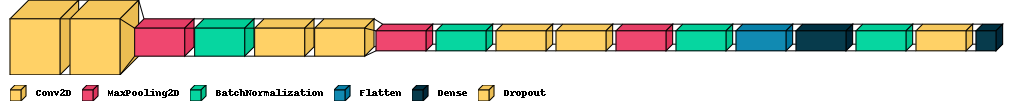

In [118]:
# Generating the image for model architecture
visualkeras.layered_view(model_VGG_2_improved, scale_xy=2, scale_z=1, max_z=50, legend=True)

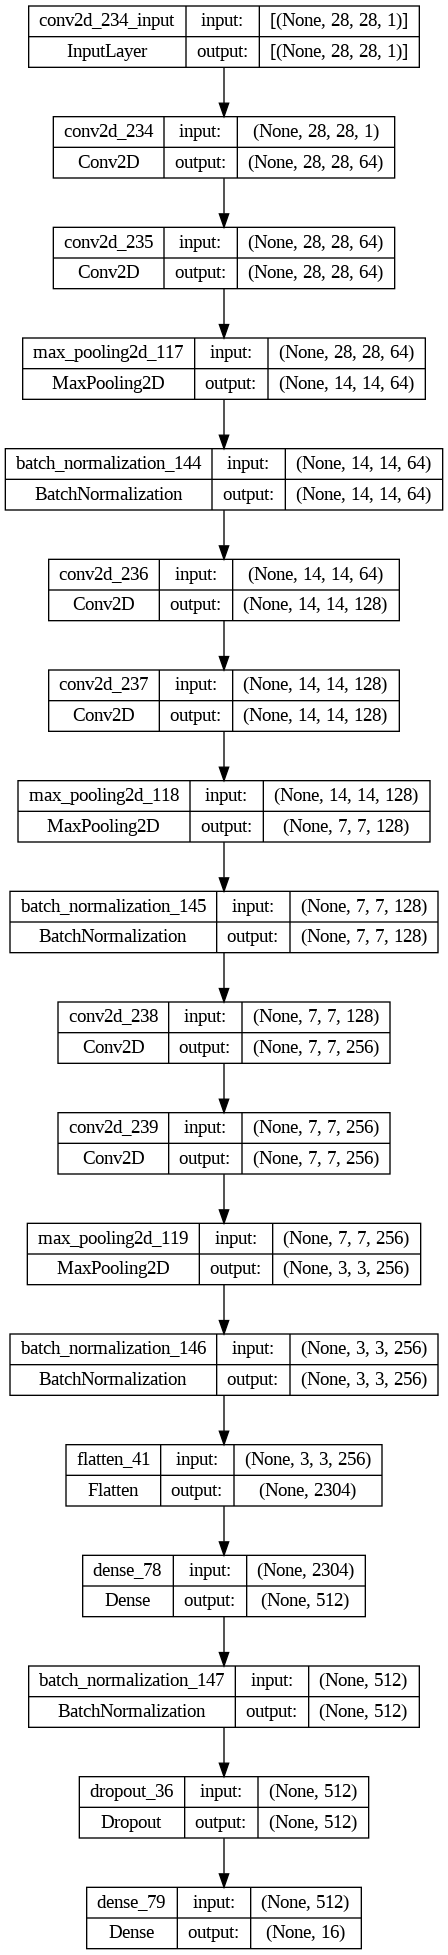

In [119]:
tf.keras.utils.plot_model(model_VGG_2_improved, show_shapes=True)

Fit the model

In [120]:
f1_score_callback_vgg_type_improved = F1ScoreCallback(model_VGG_2_improved, train_generator_type, validation_generator_type)

history_VGG_2_improved = model_VGG_2_improved.fit(
    train_generator_type,
    validation_data=validation_generator_type,
    epochs=50,
    verbose=0,
    callbacks=[f1_score_callback_vgg_type_improved]
)

12/12 [==============================] - 0s 6ms/step
Epoch 1 - Train F1: 0.0235, Validation F1: 0.0220
12/12 [==============================] - 0s 5ms/step
Epoch 2 - Train F1: 0.0518, Validation F1: 0.0326
12/12 [==============================] - 0s 4ms/step
Epoch 3 - Train F1: 0.2914, Validation F1: 0.2951
12/12 [==============================] - 0s 4ms/step
Epoch 4 - Train F1: 0.7476, Validation F1: 0.7603
12/12 [==============================] - 0s 5ms/step
Epoch 5 - Train F1: 0.9628, Validation F1: 0.9394
12/12 [==============================] - 0s 5ms/step
Epoch 6 - Train F1: 0.9936, Validation F1: 0.9685
12/12 [==============================] - 0s 7ms/step
Epoch 7 - Train F1: 0.9959, Validation F1: 0.9536
12/12 [==============================] - 0s 5ms/step
Epoch 8 - Train F1: 0.9980, Validation F1: 0.9808
12/12 [==============================] - 0s 5ms/step
Epoch 9 - Train F1: 0.9986, Validation F1: 0.9741
12/12 [==============================] - 0s 5ms/step
Epoch 10 - Train F1:

Validation Loss: 0.1601


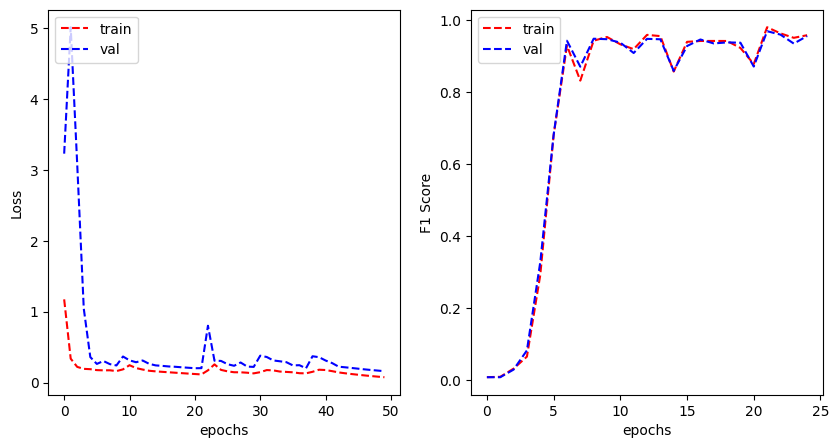

In [141]:
plot_learning_curve(history_VGG_2_improved.history['loss'],
                    history_VGG_2_improved.history['val_loss'],
                    f1_score_callback.train_f1_scores,
                    f1_score_callback.val_f1_scores,
                    metric_name='F1 Score')

In [122]:
model_VGG_2_improved.evaluate(test_generator_type)

12/12 [==============================] - 0s 7ms/step - loss: 0.0906 - categorical_accuracy: 0.9959


[0.09059857577085495, 0.995945930480957]

## 6. Testing the final model

##### Prepare data for testing

In [123]:
# internal test set
test_x = get_imgs_array(test_data['image_path'])
test_x = images_for_flow(test_x)
test_y_shape = test_data['shape_label']
test_y_type = test_data['type_label']


test_generator_shape = create_img_generator(x=test_x, y=test_y_shape, class_num=OUTPUT_CLASSES_SHAPE)

test_generator_type = create_img_generator(x=test_x, y=test_y_type, class_num=OUTPUT_CLASSES_TYPE)

In [124]:
# external test set
external_test_x = get_imgs_array(external_test_data['image_path'])
external_test_x = images_for_flow(external_test_x)
external_test_y_shape = external_test_data['shape_label']
external_test_y_type = external_test_data['type_label']


external_test_generator_shape = create_img_generator(x=external_test_x, y=external_test_y_shape, class_num=OUTPUT_CLASSES_SHAPE)

external_test_generator_type = create_img_generator(x=external_test_x, y=external_test_y_type, class_num=OUTPUT_CLASSES_TYPE)

In [125]:
def plot_test_report(model, x_set, y_set, nr_classes, label_names):

  predictions = np.argmax(model.predict(x_set / 255.0), axis=1)
  print(classification_report(y_set, predictions, target_names=label_names))
  # classes = ["Class 1", "Class 2", "Class 3", "Class 4"]

  conf_matrix = confusion_matrix(y_set, predictions)
  ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot()

  plt.xticks(rotation=45, ha='right')
  plt.show()

24/24 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

 diamond (0)       0.96      0.98      0.97        53
     hex (1)       1.00      1.00      1.00         7
   round (2)       0.99      0.99      0.99       340
  square (3)       0.99      1.00      1.00       158
triangle (4)       1.00      0.98      0.99       182

    accuracy                           0.99       740
   macro avg       0.99      0.99      0.99       740
weighted avg       0.99      0.99      0.99       740



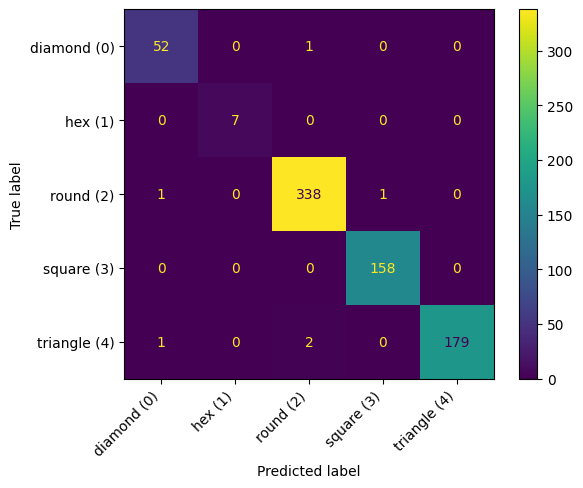

In [142]:
plot_test_report(model_VGG_1, test_x, test_y_shape, OUTPUT_CLASSES_SHAPE, shape_labels)

24/24 [==============================] - 0s 8ms/step
                      precision    recall  f1-score   support

      rightofway (0)       1.00      1.00      1.00        53
            stop (1)       1.00      1.00      1.00         7
         bicycle (2)       1.00      1.00      1.00        54
  limitedtraffic (3)       0.96      1.00      0.98        23
         noentry (4)       0.98      0.98      0.98        65
       noparking (5)       1.00      1.00      1.00        45
      roundabout (6)       1.00      1.00      1.00        20
           speed (7)       1.00      1.00      1.00        68
trafficdirective (8)       1.00      1.00      1.00        39
 traveldirection (9)       1.00      0.96      0.98        26
       continue (10)       1.00      1.00      1.00        47
       crossing (11)       1.00      1.00      1.00        15
        laneend (12)       1.00      1.00      1.00        24
        parking (13)       1.00      0.99      0.99        72
        giveway 

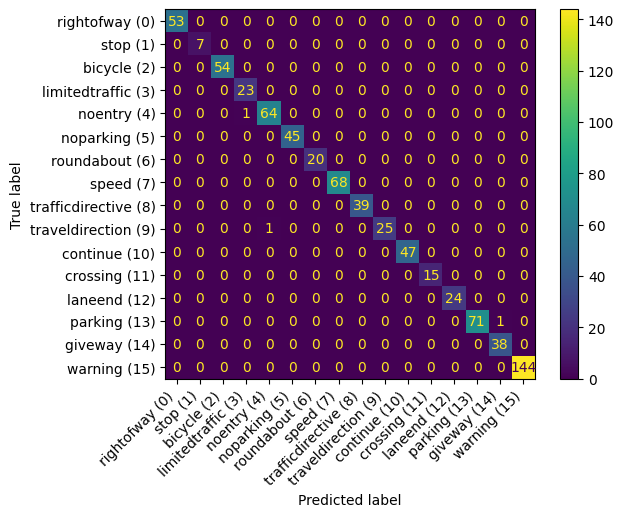

In [150]:
plot_test_report(model_VGG_2_improved, test_x, test_y_type, OUTPUT_CLASSES_TYPE, type_labels)

## 7. Conclusion


MLPs serve as a practical baseline for tasks like traffic sign classification due to their straightforward implementation and quick training. They are capable of modelling interactions between all input features, which is crucial for recognising complex patterns in the dataset. However, they are typically less effective than Convolutional Neural Networks (CNNs) for processing image data, as CNNs excel at capturing spatial hierarchies through their convolutional layers. This is evident that CNNs consistently show lower loss and higher accuracy.
In conclusion, we think Model 2.1, 2.2 (CNN) is superior.


# 8. References

- https://www.linkedin.com/pulse/classify-traffic-signs-deep-learning-james-medel/
- https://github.com/james94/P3-Traffic-Sign-Classifier-CarND/blob/master/Traffic_Sign_Classifier_with_LeNet.ipynb
- https://www.youtube.com/watch?v=jztwpsIzEGc
- https://www.datacamp.com/tutorial/cnn-tensorflow-python